[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cyneuro/Basics-of-Neurons-and-Networks/blob/main/S5_CPG/S5_CPG.ipynb)

# S5 How do tetrapods decid when to walk, trot or gallop

##### Developed in the Neural Engineering Laboratory at the University of Missouri(Mizzou) adapted from a similar GENESIS tutorial (Bower and Beeman, 2007) by Charlie Franklin and Henry Chen, converted to notebook by Ziao Chen and Zhenru Chen
##### To run code either click the play button by each code block or go to the top and select run all or runtime then run all

## Install NEURON

In [1]:
RunningInCOLAB = 'google.colab' in str(get_ipython())  # checks to see if we are in google colab
if RunningInCOLAB:                                     # installs packages if in colab 
    !pip install ipywidgets &> /dev/null
    !pip install neuron &> /dev/null

### Download modfiles from github

In [2]:
import os
from os.path import normpath, sep, join

root = 'Computational-Neuroscience-Tutorials'
folder = 'S5_CPG'
pathlist = normpath(os.getcwd()).split(sep)
if pathlist[-1] != folder:
  rootidx = pathlist.index(root) if root in pathlist else -1
  if rootidx>0:
    os.chdir(join(sep,*pathlist[:rootidx]))
  !git clone https://github.com/cyneuro/Computational-Neuroscience-Tutorials.git &> /dev/null
  os.chdir(join(root,folder))

#### Before running the simulation, you need to compile the mod files only once for the first time.

In [3]:
import os
print(os.system('nrnivmodl')) # compile modfiles. Return 0 for success, 1 for failure.

/Users/gregglickert/opt/anaconda3/envs/bmtk/bin/nrnivmodl:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set


/usr/bin/xcrun
/Users/gregglickert/Documents/GitHub/Computational-Neuroscience-Tutorials/S5_CPG
Mod files: "./extsyn.mod" "./inhsyn.mod" "./k.mod" "./leak.mod" "./na.mod"

Creating 'x86_64' directory for .o files.

 -> Compiling mod_func.cpp
 -> NMODL ../k.mod
 -> NMODL ../extsyn.mod
 -> NMODL ../inhsyn.mod
 -> NMODL ../leak.mod
 -> NMODL ../na.mod
 -> Compiling extsyn.c
 -> Compiling inhsyn.c
 -> Compiling k.c


Translating k.mod into /Users/gregglickert/Documents/GitHub/Computational-Neuroscience-Tutorials/S5_CPG/x86_64/k.c
Translating extsyn.mod into /Users/gregglickert/Documents/GitHub/Computational-Neuroscience-Tutorials/S5_CPG/x86_64/extsyn.c
Translating inhsyn.mod into /Users/gregglickert/Documents/GitHub/Computational-Neuroscience-Tutorials/S5_CPG/x86_64/inhsyn.c
Thread Safe
Thread Safe
Thread Safe
Translating leak.mod into /Users/gregglickert/Documents/GitHub/Computational-Neuroscience-Tutorials/S5_CPG/x86_64/leak.c
Translating na.mod into /Users/gregglickert/Documents/GitHub/Computational-Neuroscience-Tutorials/S5_CPG/x86_64/na.c
Thread Safe
Thread Safe
k.c:43:18: warning: a function declaration without a prototype is deprecated in all versions of C and is treated as a zero-parameter prototype in C2x, conflicting with a previous declaration [-Wdeprecated-non-prototype]
         extern double *getarg();
                        ^
/Users/gregglickert/opt/anaconda3/envs/bmtk/lib/python3.8

 -> Compiling leak.c
 -> Compiling na.c


1 warning generated.
na.c:43:18: warning: a function declaration without a prototype is deprecated in all versions of C and is treated as a zero-parameter prototype in C2x, conflicting with a previous declaration [-Wdeprecated-non-prototype]
         extern double *getarg();
                        ^
/Users/gregglickert/opt/anaconda3/envs/bmtk/lib/python3.8/site-packages/neuron/.data/include/hocdec.h:15:17: note: expanded from macro 'getarg'
#define getarg  hoc_getarg
                ^
/Users/gregglickert/opt/anaconda3/envs/bmtk/lib/python3.8/site-packages/neuron/.data/include/oc_ansi.h:49:16: note: conflicting prototype is here
extern double* getarg(int);
               ^
/Users/gregglickert/opt/anaconda3/envs/bmtk/lib/python3.8/site-packages/neuron/.data/include/hocdec.h:15:17: note: expanded from macro 'getarg'
#define getarg  hoc_getarg
                ^
1 warning generated.


 => LINKING shared library ./libnrnmech.dylib
 => LINKING executable ./special LDFLAGS are:    
Successfully created x86_64/special
0


ld: warning: ignoring duplicate libraries: '-lnrnmech'


### Run the codes below and answer the 10 questions at the end.

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from neuron import h
h.load_file('stdrun.hoc')

# Simulation parameters
h.dt = 0.025 # time step (resolution) of the simulation in ms
h.v_init= -72 # initial membrane potential in mV
h.tstop = 1000 # ms

# Single cell model
class CPGCell(object):
    def __init__(self):
        # Create cections
        self.soma = h.Section(name='soma', cell=self)
        self.dend = h.Section(name='dend', cell=self)
        # Topology
        self.dend.connect(self.soma(1),0)
        # Geometry
        self.soma.L = self.soma.diam = 30 # micrometers
        self.soma.nseg = 1
        self.dend.L = 100 # micrometers
        self.dend.diam = 2 # micrometers
        self.dend.nseg = 1
        # biophysics
        self.soma.cm = self.dend.cm = 1 # uF/cm2
        self.soma.Ra = self.dend.Ra = 50 # ohm-cm
        self.soma.insert('leak'); self.soma.insert('na'); self.soma.insert('k')
        self.soma.el_leak = -59.4; self.soma.ena = 45; self.soma.ek = -82 # mV
        self.soma.gbar_leak = 1/10000; self.soma.gbar_na = .120; self.soma.gbar_k = .036 # S/cm2
        self.dend.insert('leak')
        self.dend.el_leak = -59.4; self.dend.gbar_leak = 1/10000
        # insert IClamp
        self.ccl = h.IClamp(self.soma(0.5))
        
    def set_ccl(self,amp,dur,delay):
        self.ccl.amp = amp
        self.ccl.dur = dur
        self.ccl.delay = delay


# Cell list
NCell = 4
Cells = []
CName = ['L1','L2','R1','R2']
for i in range(NCell): Cells.append(CPGCell())

# Define vectors for recording variables and record
t_vec = h.Vector()
t_vec.record(h._ref_t);
v_vec = []
for cell in Cells:
    v_vec.append(h.Vector())
    v_vec[-1].record(cell.soma(0.5)._ref_v)

In [5]:
# Synapse default setting
syn_wgt = 100
syn_del = 15
threshold = 0

# Synapse connection object
class SynapseConnect(object):
    def __init__(self,pre_id,post_id):
        self.pre = pre_id; self.post = post_id
        self.extsyn = None; self.extnc = None
        self.inhsyn = None; self.inhnc = None

# Create synaptic connection
SynCon = []
for i in range(NCell):
    for j in range(NCell):
        if i!=j:
            SynCon.append(SynapseConnect(i,j))
            SynCon[-1].extsyn = h.ext(Cells[j].dend(0.5))
            SynCon[-1].extnc = h.NetCon(Cells[i].soma(0.5)._ref_v,SynCon[-1].extsyn,threshold,syn_del,1,sec=Cells[i].soma)
            SynCon[-1].extsyn.eext = 0;   SynCon[-1].extsyn.tau = 3
            SynCon[-1].inhsyn = h.inh(Cells[j].dend(0.5))
            SynCon[-1].inhnc = h.NetCon(Cells[i].soma(0.5)._ref_v,SynCon[-1].inhsyn,threshold,syn_del,1,sec=Cells[i].soma)
            SynCon[-1].inhsyn.einh = -75; SynCon[-1].inhsyn.tau = 25

# Set up current clamp
def set_iclamp(ccl_config):
    for i, cell in enumerate(Cells):
        cell.set_ccl(*ccl_config[i])

# Connect cells with synaptic weight and synaptic delay
def connect_cells(conn_matrix,exc_wgt=syn_wgt,inh_wgt=syn_wgt,syn_delay=None):
    for syn in SynCon:
        syntype = conn_matrix[syn.pre,syn.post]
        syn.extsyn.w = exc_wgt if syntype>0 else 0
        syn.inhsyn.w = inh_wgt if syntype<0 else 0
        if syn_delay is not None:
            syn.extnc.delay = syn.inhnc.delay = syn_delay

In [6]:
# Preset patterns
Gaits = ['Wave of Action','Walk','Trot','Pace (For you to do)']
# Current clamp configurations of Patterns. (amp,dur,delay)
Ccl_Config = {
    Gaits[0]: np.array([[0.2,0,0,0],[5]*NCell,[100]*NCell]).T,
    Gaits[1]: np.array([[0,0.2,0,0],[5]*NCell,[100]*NCell]).T,
    Gaits[2]: np.array([[0.2]*NCell,[5]*NCell,[100,110,110,100]]).T,
    Gaits[3]: np.array([[0.2]*NCell,[5]*NCell,[100,100,100,100]]).T
}
# Connection Matrix of Patterns
Conn_Matrix = {
    Gaits[0]: np.array([[0,1,0,0],[1,0,1,0],[0,1,0,1],[0,0,1,0]]),
    Gaits[1]: np.array([[0,-1,-1,1],[1,0,-1,-1],[-1,1,0,-1],[-1,-1,1,0]]),
    Gaits[2]: np.array([[0,-1,-1,1],[-1,0,1,-1],[-1,1,0,-1],[1,-1,-1,0]]),
    Gaits[3]: np.zeros((NCell,NCell))
}
# Initialize
CCL = [[0]*3 for i in range(NCell)]
CONN = np.zeros((NCell,NCell))

# Synapse Connection Graph properties
r = 1
pos = np.array([[-1,-1,1,1],[1,-1,1,-1]]).T*2*r
arr = np.zeros((4,4,4))
g = 0.05*r
for i in range(4):
    for j in range(4):
        if i!=j:
            d = pos[j]-pos[i]
            L = np.linalg.norm(d)
            arr[i,j,:2] = pos[i]+(r+g)/L*d+0.2*r*d[::-1]/L*[-1,1]
            arr[i,j,2:] = (1-2*(r+g)/L)*d
inh_style={'length_includes_head':True,'linewidth':0,'width':0.15,'head_length':0.2,'head_width':0.4,'overhang':-0.8,'color':'b'}
ext_style={'length_includes_head':True,'linewidth':0,'width':0.15,'head_length':0.2,'head_width':0.6,'overhang':-0.1,'color':'r'}

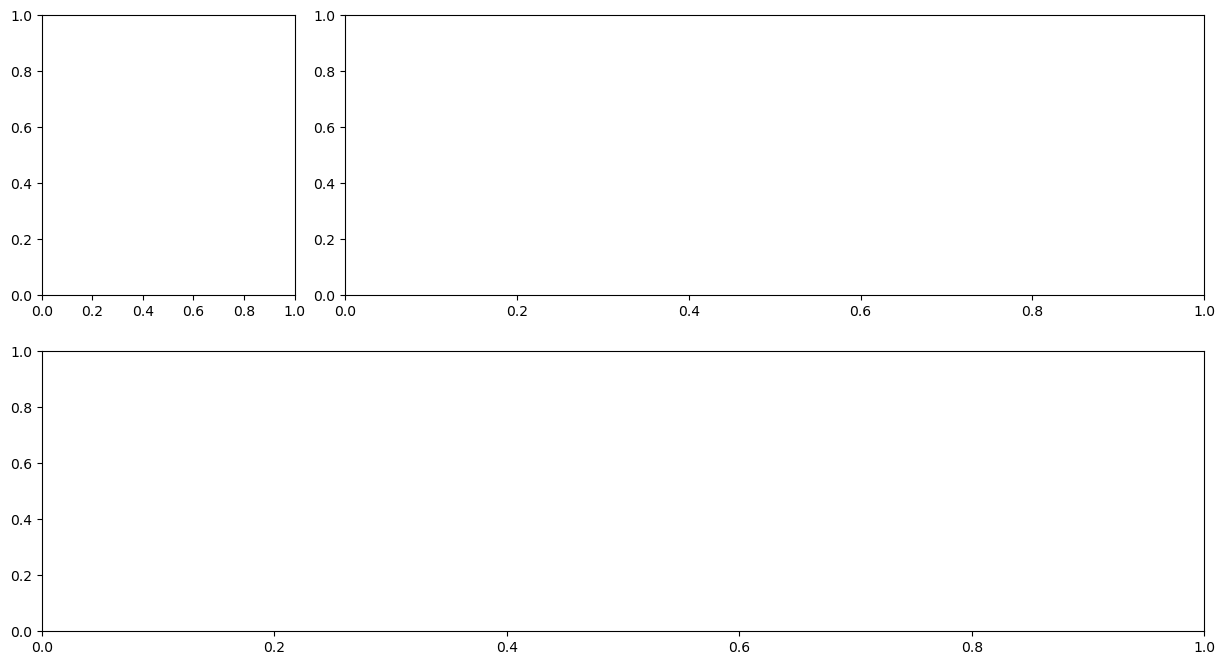

In [7]:
# Generate variable name
def Var(varname,*index):
    for ind in index:
        varname += '_'+str(ind)
    return(varname)

# Create plots
plt.ioff()
fig = plt.figure(figsize=(15,2*NCell))
ax = fig.add_subplot(241)
ax2 = plt.subplot2grid((2,4),(0,1),rowspan=1,colspan=3)
ax3 = fig.add_subplot(212)

# Draw network connection
def plot_net(**kw):
    for i in range(NCell):
        for j in range(NCell):
            if i!=j: CONN[i,j] = kw[Var('syn',i,j)]
    ax.clear()
    ax.set_xlim(-3*r,3*r)
    ax.set_ylim(-3.3*r,3.3*r)
    ax.set_axis_off()
    for i in range(4):
        ax.add_artist(plt.Circle(pos[i],1))
        ax.text(pos[i,0]-0.4,pos[i,1]-0.2,CName[i],fontsize=18,color='w')
    for i in range(4):
        for j in range(4):
            if CONN[i,j]>0: ax.arrow(*arr[i,j,:].tolist(),**ext_style)
            if CONN[i,j]<0: ax.arrow(*arr[i,j,:].tolist(),**inh_style)
    display(ax.figure)

# Build network
def build_net():
    for i in range(NCell):
        CCL[i] = [w_ccl_amp[i].value,w_ccl_dur[i].value,w_ccl_del[i].value]
    set_iclamp(CCL)
    connect_cells(CONN,exc_wgt=w_exc_wgt.value,inh_wgt=w_inh_wgt.value,syn_delay=w_syn_del.value)    

# Plot membran potentials
def plot_variables(*arg):
    build_net()
    h.run()
    ax2.clear()
    for i in range(NCell):
        ax2.plot(t_vec,v_vec[i].as_numpy()+150*(NCell-1-i))
    ax2.set_xlim(0,h.tstop)
    ax2.set_ylim(-100,NCell*150)
    ax2.legend(CName,loc=2)
    ax2.set_xlabel('Time (ms)')
    ax2.set_ylabel('Vm (mV)')
    plot_single()
    with out:
        clear_output(wait=True)
        display(ax.figure)

def plot_single(*arg):
    ax3.clear()
    ax3.plot(t_vec,v_vec[w_cell_tab.selected_index])
    ax3.set_xlim(0,h.tstop)
    ax3.set_ylim(-100,80)
    ax3.legend([CName[w_cell_tab.selected_index]],loc=2)
    ax3.set_xlabel('Time (ms)')
    ax3.set_ylabel('Vm (mV)')
    if arg:
        with out:
            clear_output(wait=True)
            display(ax.figure)

In [8]:
import ipywidgets as widgets
from ipywidgets import interactive_output,HBox,VBox,Label,Layout
from IPython.display import display, clear_output
%matplotlib inline

labels = ['Horse gait / Pattern:  ','Pre-synaptic cell: ','Current Clamp:','Amplitude (nA):','Duration (ms):','Delay (ms):',
          'Synapses parameters:','Excitatory synaptic weight:','Inhibitory synaptic weight:','Synaptic delay (ms):']
Labels = [Label(L) for L in labels]
itemgap = Label(' ',layout=Layout(width='20px'))
linegap = Label(' ',layout=Layout(height='10px'))
short_textbox = Layout(width='10%')

w_gait = widgets.ToggleButtons(value=Gaits[1],options=Gaits,button_style='info')
w_exc_wgt = widgets.BoundedFloatText(value=syn_wgt,min=0,max=1e3,step=1,layout=short_textbox)
w_inh_wgt = widgets.BoundedFloatText(value=syn_wgt,min=0,max=1e3,step=1,layout=short_textbox)
w_syn_del = widgets.BoundedFloatText(value=syn_del,min=0,max=1e3,step=1,layout=short_textbox)
w_ccl_amp = []
w_ccl_dur = []
w_ccl_del = []
w_syncon = [[] for i in range(NCell)]
cell_tab = []
w_cell_tab = widgets.Tab()
w_child_tab = [widgets.Tab() for i in range(NCell)]
dict_arg = {}

for syn in SynCon:
    w_syncon[syn.pre].append(widgets.ToggleButtons(value=0,options=[('None',0),('Excitatory',1),('Inhibitory',-1)]))
    w_syncon[syn.pre][-1].post = syn.post
    dict_arg[Var('syn',syn.pre,syn.post)] = w_syncon[syn.pre][-1]
    w_child_tab[syn.pre].set_title(len(w_syncon[syn.pre])-1,CName[syn.post])

def create_tab_layout(amp,dur,delay,tab,prename):
    line1 = VBox([Labels[2], HBox([ Labels[3],amp,itemgap,Labels[4],dur,itemgap,Labels[5],delay ]) ])
    line2 = VBox([Labels[6], HBox([ Labels[7],w_exc_wgt,itemgap,Labels[8],w_inh_wgt,itemgap,Labels[9],w_syn_del ]) ])
    line3 = VBox([Label('Synapse type from '+prename+' to (post-synaptic cell): '),tab])
    return VBox([line1,linegap,line2,linegap,line3])

for i in range(NCell):
    w_ccl_amp.append(widgets.FloatText(value=0,step=0.1,layout=short_textbox))
    w_ccl_dur.append(widgets.BoundedFloatText(value=5,min=0,max=1e3,step=1,layout=short_textbox))
    w_ccl_del.append(widgets.BoundedFloatText(value=100,min=0,max=1e3,step=1,layout=short_textbox))
    w_child_tab[i].children = w_syncon[i]
    cell_tab.append( create_tab_layout(w_ccl_amp[-1],w_ccl_dur[-1],w_ccl_del[-1],w_child_tab[i],CName[i]) )
    w_cell_tab.set_title(i,CName[i])
w_cell_tab.children = cell_tab
w_cell_tab.observe(plot_single,'selected_index')

def set_pattern(*args):
    gait = w_gait.value
    C_C = Ccl_Config[gait]
    for i in range(NCell):
        w_ccl_amp[i].value = C_C[i,0]
        w_ccl_dur[i].value = C_C[i,1]
        w_ccl_del[i].value = C_C[i,2]
    for pre, w_presyn in enumerate(w_syncon):
        for w_syn in w_presyn:
            w_syn.value = Conn_Matrix[gait][pre,w_syn.post]
    w_exc_wgt.value = syn_wgt if gait!=Gaits[0] else 40; 
    w_inh_wgt.value = syn_wgt
    w_syn_del.value = syn_del
w_gait.observe(set_pattern,'value')

run_button = widgets.Button(description='Run & Show!',icon='play-circle',button_style='success')
run_button.on_click(plot_variables)

set_pattern()
out = interactive_output(plot_net,dict_arg)
plot_variables()
ui = VBox([HBox([Labels[0],itemgap,w_gait]),Labels[1],w_cell_tab,run_button,out])
display(ui)

IndexError: list assignment index out of range

### Questions:
1. First remove all connections and convince yourself that the firing patterns of all the four neurons are identical. Next, click on ‘Walk’, and then ‘Run & Show!’. Explain how the synaptic connections implement the walk gait. Also, explain how the signal propagates. How will you slow down the pace of walking – only explain, no plot needed for this.  
<br>
2. Now explain how the synaptic connections implement the “Wave of Activation”. What is the logic to speed it up or slow it down?  
<br>  
3. Now explain how the synaptic connections implement the “Trot” gait, in a similar manner.  
<br>  
4. Finally, using the ideas from above, you are to design the connections for the ‘Pace’ gait. Use a weight of 100 for all the connections you make. Explain your LOGIC clearly (important) and include a plot of connections and of the spiking patterns of all four neurons (one of the plots on the screen).  